In [24]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [25]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, training

In [146]:
import importlib
importlib.reload(dataset)
importlib.reload(training)

<module 'eeg_project_package.training' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/training.py'>

## Check Loading of Physio Dataset Files

Number of channels:  64
Number of samples:  64


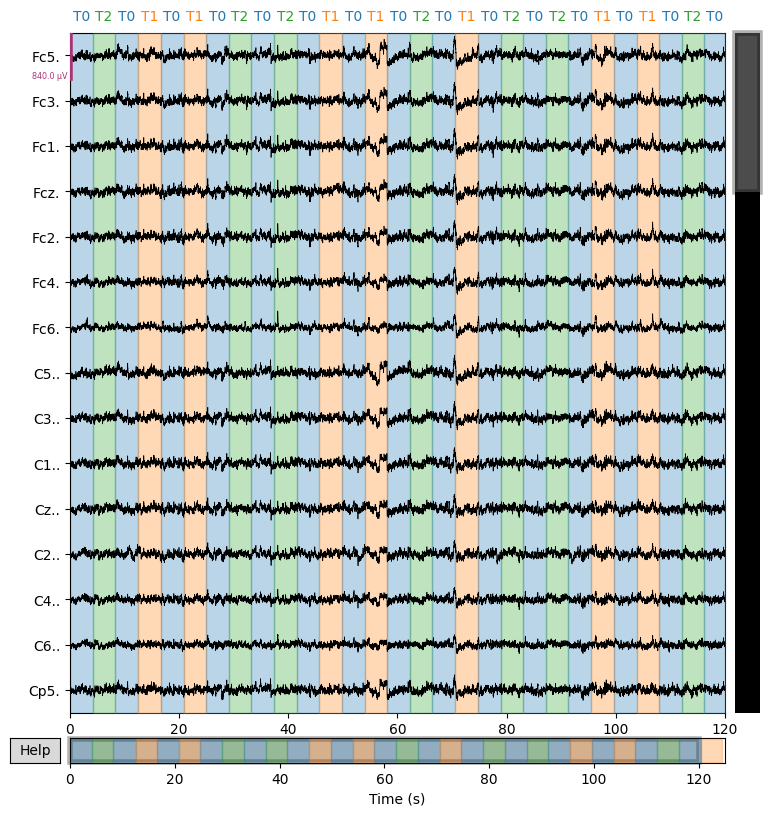

In [38]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/home/aurelien.stumpf/Code/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf"
input_fname2 =  "/home/aurelien.stumpf/Code/physionet.org/files/eegmmidb/1.0.0/S001/S001R02.edf"
input_fname3 =  "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname3, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

In [49]:
dict_channels = {'Fc5.' : 'FC5',
 'Fc3.' : 'FC3',
 'Fc1.' : 'FC1',
 'Fcz.' : 'FCz',
 'Fc2.' : 'FC2',
 'Fc4.' : 'FC4',
 'Fc6.' : 'FC6',
 'C5..' : 'C5',
 'C3..' : 'C3',
 'C1..' : 'C1',
 'Cz..' : 'Cz',
 'C2..' : 'C2',
 'C4..' : 'C4',
 'C6..' : 'C6',
 'Cp5.' : 'CP5',
 'Cp3.' : 'CP3',
 'Cp1.' : 'CP1',
 'Cpz.' : 'CPz',
 'Cp2.' : 'CP2',
 'Cp4.' : 'CP4',
 'Cp6.' : 'CP6',
 'Fp1.' : 'Fp1',
 'Fpz.' : 'Fpz',
 'Fp2.' : 'Fp2',
 'Af7.' : 'AF7',
 'Af3.' : 'AF3',
 'Afz.' : 'AFz',
 'Af4.' : 'AF4',
 'Af8.' : 'AF8',
 'F7..' : 'F7',
 'F5..' : 'F5',
 'F3..' : 'F3',
 'F1..' : 'F1',
 'Fz..' : 'Fz',
 'F2..' : 'F2',
 'F4..' : 'F4',
 'F6..' : 'F6',
 'F8..' : 'F8',
 'Ft7.' : 'FT7',
 'Ft8.' : 'FT8',
 'T7..' : 'T7',
 'T8..' : 'T8',
 'T9..' : 'T9',
 'T10.' : 'T10',
 'Tp7.' : 'TP7',
 'Tp8.' : 'TP8',
 'P7..' : 'P7',
 'P5..' : 'P5',
 'P3..' : 'P3',
 'P1..' : 'P1',
 'Pz..' : 'Pz',
 'P2..' : 'P2',
 'P4..' : 'P4',
 'P6..' : 'P6',
 'P8..' : 'P8',
 'Po7.' : 'PO7',
 'Po3.' : 'PO3',
 'Poz.' : 'POz',
 'Po4.' : 'PO4',
 'Po8.' : 'PO8',
 'O1..' : 'O1',
 'Oz..' : 'Oz',
 'O2..' : 'O2',
 'Iz..' : 'Iz'}

# Make ordered dict of channels
dict_channels_ordered = dict(sorted(dict_channels.items()))


## Time Analysis

In [137]:
list_name_channels = ["Cp1.","Cp3.","Cp5.","C1..","C3..","C5..","C2..","Cp2.","Cz..","Fcz.","C4..","Cp4."]
ch_names = raw_obj.info['ch_names']
#list_idx_channels = [ch_names.index(name) for name in list_name_channels]
list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/"

if task_type == "imaginary_feet/hand":
    num_runs = [5, 6, 9, 10, 13, 14]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
elif task_type == "imaginary_left/right":
    num_runs = [4, 8, 12]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
num_sessions = []
list_labels = [1,2]

torch_trainset = dataset.Physio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_runs, list_idx_channels, list_labels, feature_type="time")
torch_testset = dataset.Physio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_runs, list_idx_channels, list_labels, feature_type="time")
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=641,
               num_electrodes=64,
               dropout=0,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
training.train_model(model, trainloader, testloader, device, criterion, 200, optimizer, scheduler)

Epoch 0:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 8/8 [00:00<00:00,  8.76batch/s, accuracy=0.516, loss=0.0498] 

Epoch 0
lr:  0.0095
-------------------------


Train set: Avg. loss: 0.0442, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0441, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 10: 100%|██████████| 8/8 [00:00<00:00,  9.17batch/s, accuracy=0.468, loss=0.0441] 

Epoch 10
lr:  0.005688000922764597
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 20: 100%|██████████| 8/8 [00:00<00:00,  9.21batch/s, accuracy=0.5, loss=0.044]    

Epoch 20
lr:  0.0034056162628811476
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 30: 100%|██████████| 8/8 [00:00<00:00,  8.63batch/s, accuracy=0.492, loss=0.044]  

Epoch 30
lr:  0.0020390682574579037
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 40: 100%|██████████| 8/8 [00:00<00:00,  9.26batch/s, accuracy=0.444, loss=0.044] 

Epoch 40
lr:  0.0012208654873684791
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 50: 100%|██████████| 8/8 [00:00<00:00,  8.91batch/s, accuracy=0.5, loss=0.044]   

Epoch 50
lr:  0.0007309772651287747
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.4920634925365448 (49%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5079365372657776 (51%)
-------------------------


Epoch 60: 100%|██████████| 8/8 [00:00<00:00,  8.79batch/s, accuracy=0.492, loss=0.044] 

Epoch 60
lr:  0.0004376630903760434
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.4920634925365448 (49%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 70: 100%|██████████| 8/8 [00:00<00:00,  8.91batch/s, accuracy=0.548, loss=0.044] 

Epoch 70
lr:  0.00026204505914936203
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.4920634925365448 (49%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 80: 100%|██████████| 8/8 [00:00<00:00,  8.93batch/s, accuracy=0.532, loss=0.044] 

Epoch 80
lr:  0.00015689605665762893
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5634920597076416 (56%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5555555820465088 (56%)
-------------------------


Epoch 90: 100%|██████████| 8/8 [00:00<00:00,  8.92batch/s, accuracy=0.492, loss=0.044] 

Epoch 90
lr:  9.393946474175998e-05
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.4920634925365448 (49%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 100: 100%|██████████| 8/8 [00:00<00:00,  8.96batch/s, accuracy=0.516, loss=0.044] 

Epoch 100
lr:  5.6245027593172946e-05
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5317460298538208 (53%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.523809552192688 (52%)
-------------------------


Epoch 110: 100%|██████████| 8/8 [00:00<00:00,  9.24batch/s, accuracy=0.532, loss=0.044] 

Epoch 110
lr:  3.367597566851452e-05
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5952380895614624 (60%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5873016119003296 (59%)
-------------------------


Epoch 120: 100%|██████████| 8/8 [00:00<00:00,  8.85batch/s, accuracy=0.571, loss=0.044] 

Epoch 120
lr:  2.0163050597632492e-05
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.579365074634552 (58%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.579365074634552 (58%)
-------------------------


Epoch 130: 100%|██████████| 8/8 [00:00<00:00,  8.42batch/s, accuracy=0.571, loss=0.044] 

Epoch 130
lr:  1.2072363200535039e-05
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.6269841194152832 (63%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5952380895614624 (60%)
-------------------------


Epoch 140: 100%|██████████| 8/8 [00:00<00:00,  9.05batch/s, accuracy=0.563, loss=0.044] 

Epoch 140
lr:  7.228169792062385e-06
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
-------------------------


Epoch 150: 100%|██████████| 8/8 [00:00<00:00,  9.01batch/s, accuracy=0.571, loss=0.044] 

Epoch 150
lr:  4.32777225759474e-06
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
-------------------------


Epoch 160: 100%|██████████| 8/8 [00:00<00:00,  8.99batch/s, accuracy=0.579, loss=0.044] 

Epoch 160
lr:  2.5911971152330426e-06
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
-------------------------


Epoch 170: 100%|██████████| 8/8 [00:00<00:00,  8.93batch/s, accuracy=0.563, loss=0.044] 

Epoch 170
lr:  1.5514454297379485e-06
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5873016119003296 (59%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.579365074634552 (58%)
-------------------------


Epoch 180: 100%|██████████| 8/8 [00:00<00:00,  8.91batch/s, accuracy=0.571, loss=0.044] 

Epoch 180
lr:  9.2890768799667e-07
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
-------------------------


Epoch 190: 100%|██████████| 8/8 [00:00<00:00,  8.93batch/s, accuracy=0.571, loss=0.044] 

Epoch 190
lr:  5.561713459461251e-07
-------------------------


Train set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
Test set: Avg. loss: 0.0440, Balanced Accuracy: 0.5714285969734192 (57%)
-------------------------


Epoch 199: 100%|██████████| 8/8 [00:00<00:00,  9.17batch/s, accuracy=0.571, loss=0.044] 


In [39]:
def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[dict_channels[channel]])
    return positions

In [121]:
montage = mne.channels.make_standard_montage('standard_1020')

def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[dict_channels[channel]])
    return positions

ch_positions = np.array(get_positions_from_channel_list(list_all_ch_names, montage))

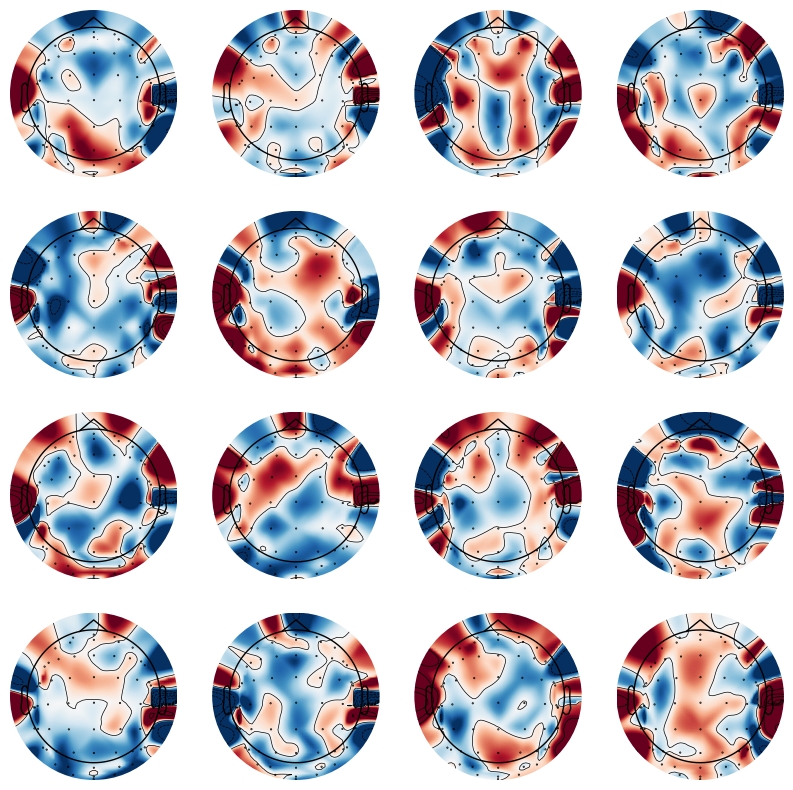

In [122]:
# display head topomap of all spatial filters 
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        mne.viz.plot_topomap(
            model.block1[2].weight.data[i + 4 * j].cpu().numpy().flatten(),
            ch_positions[:, :2],
            show=False,
            axes=ax[i, j]
        )

plt.show()
        

## PSD Dataset

In [116]:
list_idx_channels = list(range(0, 64))

trainset = dataset.Physio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_runs, list_idx_channels, list_labels, feature_type="psd")
testset = dataset.Physio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_runs, list_idx_channels, list_labels, feature_type="psd")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

In [117]:
X_train = trainset.features.reshape(trainset.features.shape[0], -1)
y_train = trainset.labels
X_test = testset.features.reshape(testset.features.shape[0], -1)
y_test = testset.labels

# Train LDA classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA Accuracy: ", acc)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM Accuracy: ", acc)

# Train XGBoost classifier
bst = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.0005, objective='binary:logistic')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
acc = np.mean(preds == y_test)
print("XGBoost Accuracy: ", acc)

LDA Accuracy:  0.5476190476190477
SVM Accuracy:  0.5
XGBoost Accuracy:  0.6031746031746031


## DGCNN

In [147]:
list_name_channels = ["Cp1.","Cp3.","Cp5.","C1..","C3..","C5..","C2..","Cp2.","Cz..","Fcz.","C4..","Cp4."]
ch_names = raw_obj.info['ch_names']
#list_idx_channels = [ch_names.index(name) for name in list_name_channels]
list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/"

if task_type == "imaginary_feet/hand":
    num_runs = [5, 6, 9, 10, 13, 14]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
elif task_type == "imaginary_left/right":
    num_runs = [4, 8, 12]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
num_sessions = []
list_labels = [1,2]

torch_trainset = dataset.Physio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_runs, list_idx_channels, list_labels, feature_type="band")
torch_trainset.transform_dataset_numpy_to_torch()
torch_testset = dataset.Physio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_runs, list_idx_channels, list_labels, feature_type="band")
torch_testset.transform_dataset_numpy_to_torch()
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [150]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = DGCNN(in_channels=5, num_electrodes=64, hid_channels=128, num_layers=3, num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
training.train_model(model, trainloader, testloader, device, criterion, 100, optimizer, scheduler)

Epoch 0:   0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 83/83 [00:01<00:00, 59.35batch/s, accuracy=0.662, loss=0.041]  


Epoch 0
lr:  0.0095
-------------------------
Train set: Avg. loss: 0.0405, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0405, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 10: 100%|██████████| 83/83 [00:01<00:00, 62.20batch/s, accuracy=0.667, loss=0.04]   


Epoch 10
lr:  0.005688000922764597
-------------------------
Train set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 20: 100%|██████████| 83/83 [00:01<00:00, 60.13batch/s, accuracy=0.667, loss=0.0399] 


Epoch 20
lr:  0.0034056162628811476
-------------------------
Train set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 30: 100%|██████████| 83/83 [00:01<00:00, 59.61batch/s, accuracy=0.667, loss=0.0399] 

Epoch 30
lr:  0.0020390682574579037
-------------------------


Train set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 40: 100%|██████████| 83/83 [00:01<00:00, 58.02batch/s, accuracy=0.667, loss=0.04]   

Epoch 40
lr:  0.0012208654873684791
-------------------------


Train set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 50: 100%|██████████| 83/83 [00:01<00:00, 58.21batch/s, accuracy=0.667, loss=0.0399] 


Epoch 50
lr:  0.0007309772651287747
-------------------------
Train set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 60: 100%|██████████| 83/83 [00:01<00:00, 61.76batch/s, accuracy=0.667, loss=0.04]   


Epoch 60
lr:  0.0004376630903760434
-------------------------
Train set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 70: 100%|██████████| 83/83 [00:01<00:00, 60.73batch/s, accuracy=0.667, loss=0.0399] 


Epoch 70
lr:  0.00026204505914936203
-------------------------
Train set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0400, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 80: 100%|██████████| 83/83 [00:01<00:00, 59.14batch/s, accuracy=0.667, loss=0.0399] 


Epoch 80
lr:  0.00015689605665762893
-------------------------
Train set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 90: 100%|██████████| 83/83 [00:01<00:00, 59.03batch/s, accuracy=0.667, loss=0.0399] 

Epoch 90
lr:  9.393946474175998e-05
-------------------------


Train set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0399, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 99: 100%|██████████| 83/83 [00:01<00:00, 61.94batch/s, accuracy=0.667, loss=0.0399] 
